# Создание модели прогнозирования заболеваемости населения

## Чемпионат Тульская область

9 августа — 2 сентября 2022

In [1]:
#!cp /content/drive/MyDrive/Colab/Data/'Готовые задачи'/Калининград/participants/train/train.csv ./ 
#!cp /content/drive/MyDrive/Colab/Data/'Готовые задачи'/Калининград/participants/test/test.csv ./ 

In [2]:
#Установка catboost
#!pip install catboost

In [3]:
import time
start_time = time.time()

In [4]:
#import необходимых модулей

import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt

In [5]:
#Считывание данных в DataFrame 

train = pd.read_csv('train.csv', sep=';', index_col=None, dtype={'PATIENT_SEX':str, 'MKB_CODE':str, 'ADRES':str, 'VISIT_MONTH_YEAR':str, 'AGE_CATEGORY':str, 'PATIENT_ID_COUNT':int})
test = pd.read_csv('test.csv', sep=';', index_col=None, dtype={'PATIENT_SEX':str, 'MKB_CODE':str, 'ADRES':str, 'VISIT_MONTH_YEAR':str, 'AGE_CATEGORY':str})

### Исследование данных

In [6]:
train.head()

,PATIENT_SEX,MKB_CODE,ADRES,VISIT_MONTH_YEAR,AGE_CATEGORY,PATIENT_ID_COUNT
0,0,A00.0,Гурьевск,08.21,young,1
1,0,A00.0,Калининград,03.20,children,1
2,0,A00,Гусев,03.19,children,1
3,0,A00,Калининград,01.22,children,1
4,0,A00,Калининград,02.18,children,1


In [7]:
test.head()

,PATIENT_SEX,MKB_CODE,ADRES,VISIT_MONTH_YEAR,AGE_CATEGORY
0,0,A00,Калининград,04.22,children
1,0,A00,Калининград,04.22,elderly
2,0,A00,Калининград,04.22,middleage
3,0,A00,Калининград,04.22,young
4,0,A01,Калининград,04.22,middleage


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2212393 entries, 0 to 2212392
Data columns (total 6 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   PATIENT_SEX       object
 1   MKB_CODE          object
 2   ADRES             object
 3   VISIT_MONTH_YEAR  object
 4   AGE_CATEGORY      object
 5   PATIENT_ID_COUNT  int32 
dtypes: int32(1), object(5)
memory usage: 92.8+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39373 entries, 0 to 39372
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   PATIENT_SEX       39373 non-null  object
 1   MKB_CODE          39373 non-null  object
 2   ADRES             39373 non-null  object
 3   VISIT_MONTH_YEAR  39373 non-null  object
 4   AGE_CATEGORY      39373 non-null  object
dtypes: object(5)
memory usage: 1.5+ MB


In [10]:
train.isna().sum()

PATIENT_SEX         0
MKB_CODE            0
ADRES               0
VISIT_MONTH_YEAR    0
AGE_CATEGORY        0
PATIENT_ID_COUNT    0
dtype: int64

In [11]:
train.describe()

,PATIENT_ID_COUNT
count,2.212393e+06
mean,5.847853e+00
std,6.042780e+01
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,1.353200e+04


In [12]:
train['PATIENT_SEX'].value_counts()

0    1316709
1     895684
Name: PATIENT_SEX, dtype: int64

In [13]:
train['MKB_CODE'].value_counts()

J06.9    19100
I11.9    17282
Z00.0    15419
Z02.7    13458
K02.1    13132
         ...  
D76.1        1
Z44.3        1
D80.7        1
D82.9        1
Z96.2        1
Name: MKB_CODE, Length: 7644, dtype: int64

In [14]:
train['ADRES'].value_counts()

Калининград           617129
Гурьевск              116111
Светлый                85748
Пионерский             84932
Советск                78466
                       ...  
Ясная Поляна            2670
Малинники               2649
Гурьевский              2635
СТ Радуга               2588
СТ Железнодорожник      2517
Name: ADRES, Length: 118, dtype: int64

In [15]:
train['ADRES'][train['PATIENT_ID_COUNT'] > 100].value_counts()

Калининград        11989
Гурьевск             629
Пионерский           287
Зеленоградск         235
Черняховск           197
Советск              186
Светлый              150
Гусев                147
Балтийск             145
Гвардейск            138
Багратионовск        132
Правдинск             94
Славск                58
Неман                 54
Светлогорск           47
Озерск                46
Нестеров              39
Полесск               39
Краснознаменск        33
Мамоново              28
Васильково            13
Большое Исаково        9
Прибрежный             3
Янтарный               2
Name: ADRES, dtype: int64

In [16]:
train['VISIT_MONTH_YEAR'].value_counts()

10.19    63145
04.19    61646
12.19    60759
10.18    60258
11.18    58999
03.19    58933
07.19    58811
11.19    58485
09.19    57688
02.19    57278
12.18    56813
03.18    56510
08.19    56411
04.18    56068
07.18    55876
05.19    55516
02.18    55369
06.19    55302
06.18    55048
08.18    55040
05.18    55023
09.18    53682
01.19    53661
01.18    50770
03.22    36298
10.20    35684
09.20    35458
04.21    34922
12.21    34720
06.21    34547
09.21    34471
03.20    34416
02.20    34376
03.21    34137
07.21    33806
11.21    33548
08.21    33153
07.20    33073
10.21    33057
05.21    32948
08.20    32434
01.20    30550
11.20    29442
02.21    29176
06.20    29166
12.20    28624
01.22    25743
02.22    24348
01.21    22959
04.20    22893
05.20    21353
Name: VISIT_MONTH_YEAR, dtype: int64

In [17]:
train['AGE_CATEGORY'].value_counts()

young           552363
elderly         514680
middleage       438426
children        430511
old             214493
centenarians     61920
Name: AGE_CATEGORY, dtype: int64

In [18]:
train['PATIENT_ID_COUNT'].value_counts()

1       1366778
2        318988
3        136250
4         77480
5         50492
         ...   
1241          1
4501          1
1166          1
1415          1
6733          1
Name: PATIENT_ID_COUNT, Length: 1688, dtype: int64

In [19]:
test.describe()

,PATIENT_SEX,MKB_CODE,ADRES,VISIT_MONTH_YEAR,AGE_CATEGORY
count,39373,39373,39373,39373,39373
unique,2,4106,20,1,6
top,0,J06.9,Калининград,04.22,elderly
freq,23099,209,13729,39373,9273


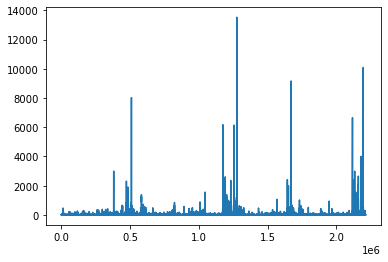

In [20]:
train['PATIENT_ID_COUNT'].plot()
plt.show()

### Решение

In [21]:
# Преобразование VISIT_MONTH_YEAR to_datetime

In [22]:
train['VISIT_MONTH_YEAR']=train['VISIT_MONTH_YEAR'].astype(str)
train['VISIT_MONTH_YEAR'] = '01.' +  train['VISIT_MONTH_YEAR']
train['VISIT_MONTH_YEAR'] = pd.to_datetime(train['VISIT_MONTH_YEAR'], dayfirst=True)

In [23]:
test1 = test.copy()
test1['VISIT_MONTH_YEAR']=test['VISIT_MONTH_YEAR'].astype(str)
test1['VISIT_MONTH_YEAR'] = '01.' +  test1['VISIT_MONTH_YEAR']
test1['VISIT_MONTH_YEAR'] = pd.to_datetime(test1['VISIT_MONTH_YEAR'], dayfirst=True)

In [24]:
#Отделение меток от данных

X = train[['PATIENT_SEX', 'MKB_CODE', 'ADRES', 'VISIT_MONTH_YEAR', 'AGE_CATEGORY']]
y = train[['PATIENT_ID_COUNT']]

In [25]:
#Разделение на train/test для локального тестирования

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [26]:
#Создание объекта данных Pool, плюсы: возможность указать какие признаки являются категориальными

pool_train = Pool(X_train, y_train, cat_features = ['PATIENT_SEX', 'MKB_CODE', 'ADRES', 'AGE_CATEGORY'])
pool_test = Pool(X_test, cat_features = ['PATIENT_SEX', 'MKB_CODE', 'ADRES', 'AGE_CATEGORY'])

In [27]:
#Объявление CatBoostRegressor и обучение

#model = CatBoostRegressor(task_type='GPU')
model = CatBoostRegressor(depth = 7, iterations = 1000)
model.fit(pool_train,verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [28]:
#Получение ответов модели на тестовой выборке в локальном тестировании 

y_pred = model.predict(pool_test)

In [29]:
#На локальном тестировании модель выдаёт такой результат

print("Значение метрики R2 на test: ", r2_score(y_test, y_pred))

Значение метрики R2 на test:  0.9255703980885073


In [30]:
#Формируем sample_solution. В обучении используется весь train, ответы получаем на test

pool_train_solution = Pool(X, y, cat_features = ['PATIENT_SEX', 'MKB_CODE', 'ADRES', 'AGE_CATEGORY'])
pool_test_solution = Pool(test, cat_features = ['PATIENT_SEX', 'MKB_CODE', 'ADRES', 'AGE_CATEGORY'])

#model_solution = CatBoostRegressor(task_type='GPU')
#model_solution = CatBoostRegressor(depth = 7, iterations = 1000)
#model_solution.fit(pool_train_solution,verbose=False, plot=True)

In [31]:
#Получение ответов

y_pred_solution = model.predict(pool_test_solution)

In [32]:
y_pred_solution

array([0.62080031, 1.19084296, 1.1200607 , ..., 1.14489663, 1.13466588,
       1.20294743])

In [33]:
#Вот так они выглядят

y_pred_solution.astype(int)

array([0, 1, 1, ..., 1, 1, 1])

In [34]:
#Формируем sample_solution для отправки на платформу

test['PATIENT_ID_COUNT'] = y_pred_solution.astype(int)

In [35]:
# Обнуление отрицательных значений PATIENT_ID_COUNT
#test[test['PATIENT_ID_COUNT'] < 0]
test.loc[(test['PATIENT_ID_COUNT'] < 0), 'PATIENT_ID_COUNT'] = 0 

In [36]:
#Сохраняем в csv файл
 
test.to_csv('sample_solution.csv', sep=';', index=None)

In [37]:
#model_solution.plot_tree(tree_idx=0)

In [38]:
# CatBoost дает нам словарь со всеми параметрами модели. Мы можем вывести их, как словарь.
#or key,value in model_solution.get_all_params().items():
for key,value in model.get_all_params().items():
     print('{}, {}'.format(key,value))

nan_mode, Min
eval_metric, RMSE
combinations_ctr, ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']
iterations, 1000
sampling_frequency, PerTree
fold_permutation_block, 0
leaf_estimation_method, Newton
counter_calc_method, SkipTest
grow_policy, SymmetricTree
penalties_coefficient, 1
boosting_type, Plain
model_shrink_mode, Constant
feature_border_type, GreedyLogSum
ctr_leaf_count_limit, 18446744073709551615
bayesian_matrix_reg, 0.10000000149011612
one_hot_max_size, 2
force_unit_auto_pair_weights, False
l2_leaf_reg, 3
random_strength, 1
rsm, 1
boost_from_average, True
max_ctr_complexity, 4
model_size_reg, 0.5
simple_ctr, ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']
pool_metainfo_options, {'tags': {}}
s

In [39]:
# 220824_00 Значение метрики R2 на test:  0.8682238751045731 0.531098 
# 220825_01 Значение метрики R2 на test:  0.8682238751045731
# 220825_02 Значение метрики R2 на test:  0.8537825457775633  Score = 0.414966  №79 depth = 5

# 220826_03 Значение метрики R2 на test:  0.8798539416234589  Score = 0.532510  №67 depth = 7 test_size=0.20
# 220826_04 Значение метрики R2 на test:  0.8842473246221985  Score = 0.372336  №82 depth = 8 iterations 1000
# 220826_04 Значение метрики R2 на test:  0.8842473246221985  Score = 0.372336  №82 depth = 8 iterations 1000
# 220826_05 Значение метрики R2 на test:  0.8864871709291094  Score = 0.369445  №83 depth = 8 iterations 600
# 220826_06 Значение метрики R2 на test:  0.8794358366101589  Score = 0.383821  №81 depth = 7 iterations 600
# 220826_07 Значение метрики R2 на test:  0.8798539416234589  Score = 0.532510  №81 depth = 7 iterations 1000 random_state=1  1428.6709322929382 
# 220826_08 Значение метрики R2 на test:  0.9260984965259902  Score = 0.230134  №81 depth = 7 test_size=0.10 iterations 1000 random_state=1  1479.8006992340088 
# 220826_09  - to 0                                           Score = 0.290758

# 220827_10 R2 на test:  0.8798539416234589  Score = 0.548104  №60 depth = 7 iterations 1000 random_state=1  test_size=0.20 -to0
# 220827_11 R2 на test:  0.9255703980885073  Score = 0.851569  №24 depth = 7 iterations 1000 random_state=1  test_size=0.20 -to0 to_datetime
# 220827_12 R2 на test:  0.9255703980885073  Score = 0.794988  №30 depth = 7 iterations 1000 random_state=1  test_size=0.20 -to0 to_datetime  round
# 220827_13 R2 на test:  0.9213149495331469  Score = 0.781080  №32 depth = 7 iterations 1250 random_state=1  test_size=0.20 -to0 to_datetime  
# 220827_14 R2 на test:  0.9345372760719973  Score = 0.790558  №31 depth = 7 iterations 1000 random_state=42  test_size=0.20 -to0 to_datetime
# выбросы
# 220827_15 R2 на test:  0.8427967663252991  Score = 0.132736  №93 depth = 7 iterations 1000 random_state=42  test_size=0.20 -to0 to_datetime  выбр100
# 220827_16 R2 на test:  0.9190516940540618  Score = 0.524285  №75 depth = 7 iterations 1000 random_state=42  test_size=0.20 -to0 to_datetime  выбр1000
# 220827_16 R2 на test:  0.9190516940540618  Score = 0.524285  №75 depth = 7 iterations 1000 random_state=42  test_size=0.20 -to0 to_datetime  выбр10000

# 220828_17 R2 на test:  0.9330170609283756  Score = 0.784042  №34 depth = 7 iterations 1000 random_state=1  test_size=0.20 -to0 to_datetime  выбр10000
# 220828_18 R2 на test:  0.9255703980885073  Score = 0.784042  №34 depth = 7 iterations 1000 random_state=1  test_size=0.20 -to0 to_datetime
# 220828_19 R2 на test:  0.9400620010941232  Score = 0.790992  №35 depth = 7 iterations 1000 random_state=1  test_size=0.20 -to0 to_datetime  drop10000

# 220829_20 R2 на test:  0.9344496901857704  Score = 0.786412  №38 depth = 7 iterations 1000 random_state=1  test_size=0.20 -to0 to_datetime  drop1000
# 220829_21 220827_11 R2 0.9255703980885073  Score = 0.794261  №37 depth = 7 iterations 1000 random_state=1  test_size=0.20 -to0 to_datetime
# 220829_22 R2 на test:  0.9255703980885073  Score =    №  depth = 7 iterations 1000 random_state=42 test_size=0.20 -to0 to_datetime


In [40]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 750.8684842586517 seconds ---


In [41]:
import winsound
duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)